In [99]:
import pandas as pd
import numpy as np

In [100]:
url = 'https://raw.githubusercontent.com/azou0/Dataset/refs/heads/main/kick.csv'

In [101]:
df = pd.read_csv(url)

C:\Users\23179\AppData\Local\Temp\ipykernel_28192\4176769558.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [102]:
# Calculate proportion of values of the target variable

before_counts = df["IsBadBuy"].value_counts(dropna=False)
before_proportion = before_counts / len(df)

print("Before preprocessing:")
print(pd.DataFrame({"Count": before_counts, "Proportion": before_proportion}))

Before preprocessing:
          Count  Proportion
IsBadBuy                   
0         36105    0.870503
1          5371    0.129497


Before preprocessing, the target variable IsBadBuy consisted of:

Class 0 (Good Buy): 0.870503% of records

Class 1 (Bad Buy):  0.129497% of records

Missing: 0% of records

Initial check

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41476 entries, 0 to 41475
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PurchaseID                         41476 non-null  int64  
 1   PurchaseTimestamp                  41476 non-null  int64  
 2   PurchaseDate                       41476 non-null  object 
 3   Auction                            41432 non-null  object 
 4   VehYear                            41432 non-null  float64
 5   Make                               41432 non-null  object 
 6   Color                              41432 non-null  object 
 7   Transmission                       41432 non-null  object 
 8   WheelTypeID                        41432 non-null  object 
 9   WheelType                          41380 non-null  object 
 10  VehOdo                             41432 non-null  float64
 11  Nationality                        41432 non-null  obj

From the initial inspection, the dataset contained several variables stored as object (string) or incorrect numeric types.

PurchaseDate was stored as object, PurchaseTimestamp was stored as integer.

Many price and odometer variables (MMR..., VehBCost, WarrantyCost, etc.) were stored as object instead of numeric.

Columns such as PRIMEUNIT, IsOnlineSale were stored as object instead of integers.

Manufacturer, color, region, and similar fields were stored as object instead of category type.

In [104]:
df = df.drop(columns=['PurchaseID'])

conversion process

In [105]:

df["PurchaseDate"] = pd.to_datetime(df["PurchaseDate"], errors="coerce")


df["PurchaseTimestamp"] = pd.to_datetime(df["PurchaseTimestamp"], unit="s", errors="coerce")


numeric_columns = [
    "VehYear", "VehOdo", "VehBCost", "WarrantyCost",
    "MMRAcquisitionAuctionAveragePrice", "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionAveragePrice", "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice",
    "MMRCurrentRetailRatio"
]
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce")


binary_columns = ["IsOnlineSale"]
for column in binary_columns:
    df[column] = pd.to_numeric(df[column], errors="coerce").astype("Int64")


category_columns = [
    "Auction", "Make", "Color", "Transmission", "WheelTypeID", "WheelType",
    "Nationality", "Size", "AUCGUART", "VNST","TopThreeAmericanName", 
]
for column in category_columns:
    df[column] = df[column].astype("category")


print(df.dtypes)

C:\Users\23179\AppData\Local\Temp\ipykernel_28192\1863944543.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["PurchaseDate"] = pd.to_datetime(df["PurchaseDate"], errors="coerce")


PurchaseTimestamp                    datetime64[ns]
PurchaseDate                         datetime64[ns]
Auction                                    category
VehYear                                     float64
Make                                       category
Color                                      category
Transmission                               category
WheelTypeID                                category
WheelType                                  category
VehOdo                                      float64
Nationality                                category
Size                                       category
TopThreeAmericanName                       category
MMRAcquisitionAuctionAveragePrice           float64
MMRAcquisitionAuctionCleanPrice             float64
MMRAcquisitionRetailAveragePrice            float64
MMRAcquisitonRetailCleanPrice               float64
MMRCurrentAuctionAveragePrice               float64
MMRCurrentAuctionCleanPrice                 float64
MMRCurrentRe

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

Checking redundancy

To reduce the complexity of the modelling process, we need to reduce the dimensionality of the dataset. 
We identify and remove columns that carry overlapping information.
Several columns might be redundant. The dataset contains multiple price variables for different market types. WheelTypeID and WheelType describe the same feature in different formats. Also, PurchaseDate and PurchaseTimestamp both represent the purchase date/time.
I checked the correlation between those columns.

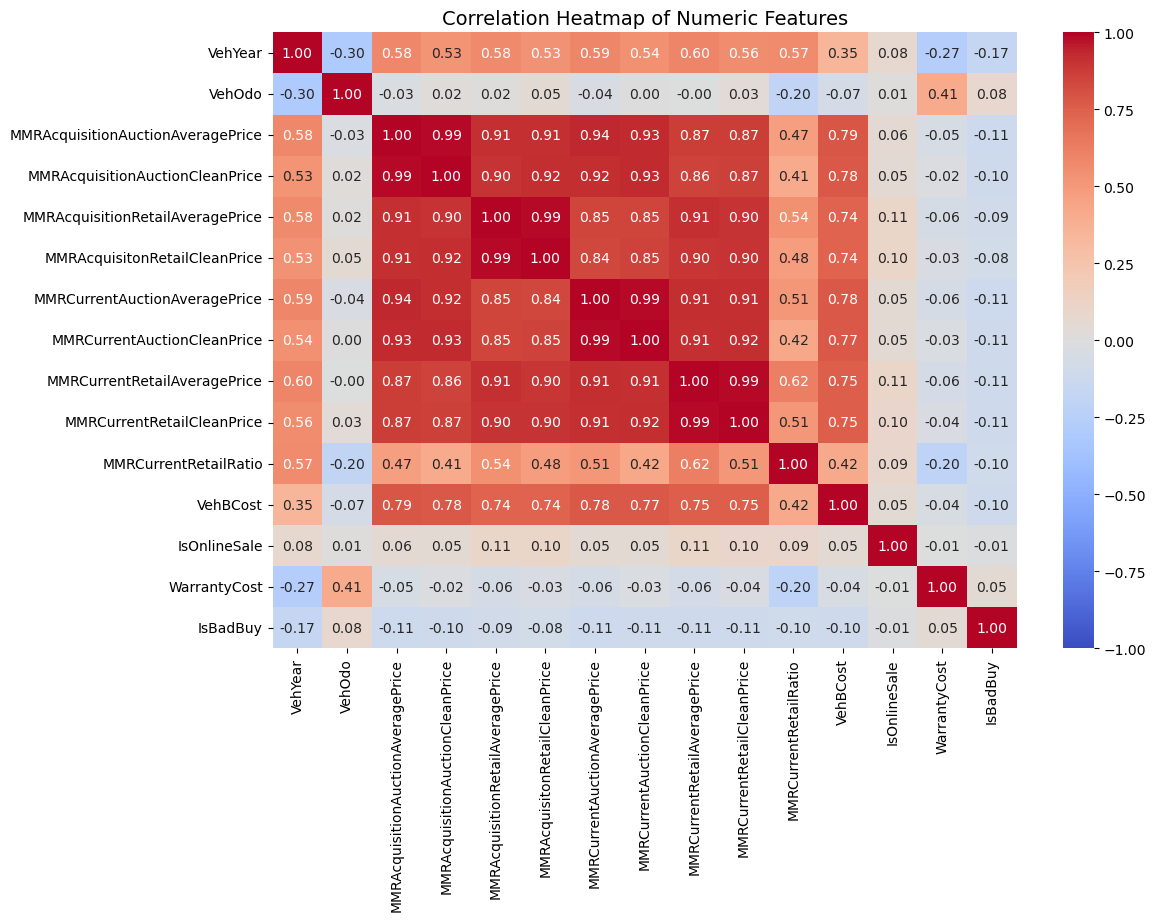

In [107]:

numeric_df = df.select_dtypes(include=["float64", "int64", "Int64"])


corr_matrix = numeric_df.corr()


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.show()

In [108]:
# Select only the price columns
mmr_cols = [
    "MMRAcquisitionAuctionAveragePrice",
    "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitionRetailAveragePrice",
    "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionAveragePrice",
    "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailAveragePrice",
    "MMRCurrentRetailCleanPrice",
    "MMRCurrentRetailRatio"
]

mmr_df = df[mmr_cols]

# Check correlations
correlation_matrix = mmr_df.corr()

print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
                                    MMRAcquisitionAuctionAveragePrice  \
MMRAcquisitionAuctionAveragePrice                           1.000000   
MMRAcquisitionAuctionCleanPrice                             0.990273   
MMRAcquisitionRetailAveragePrice                            0.910271   
MMRAcquisitonRetailCleanPrice                               0.909688   
MMRCurrentAuctionAveragePrice                               0.935041   
MMRCurrentAuctionCleanPrice                                 0.929234   
MMRCurrentRetailAveragePrice                                0.868028   
MMRCurrentRetailCleanPrice                                  0.867273   
MMRCurrentRetailRatio                                       0.471789   

                                   MMRAcquisitionAuctionCleanPrice  \
MMRAcquisitionAuctionAveragePrice                         0.990273   
MMRAcquisitionAuctionCleanPrice                           1.000000   
MMRAcquisitionRetailAveragePrice                

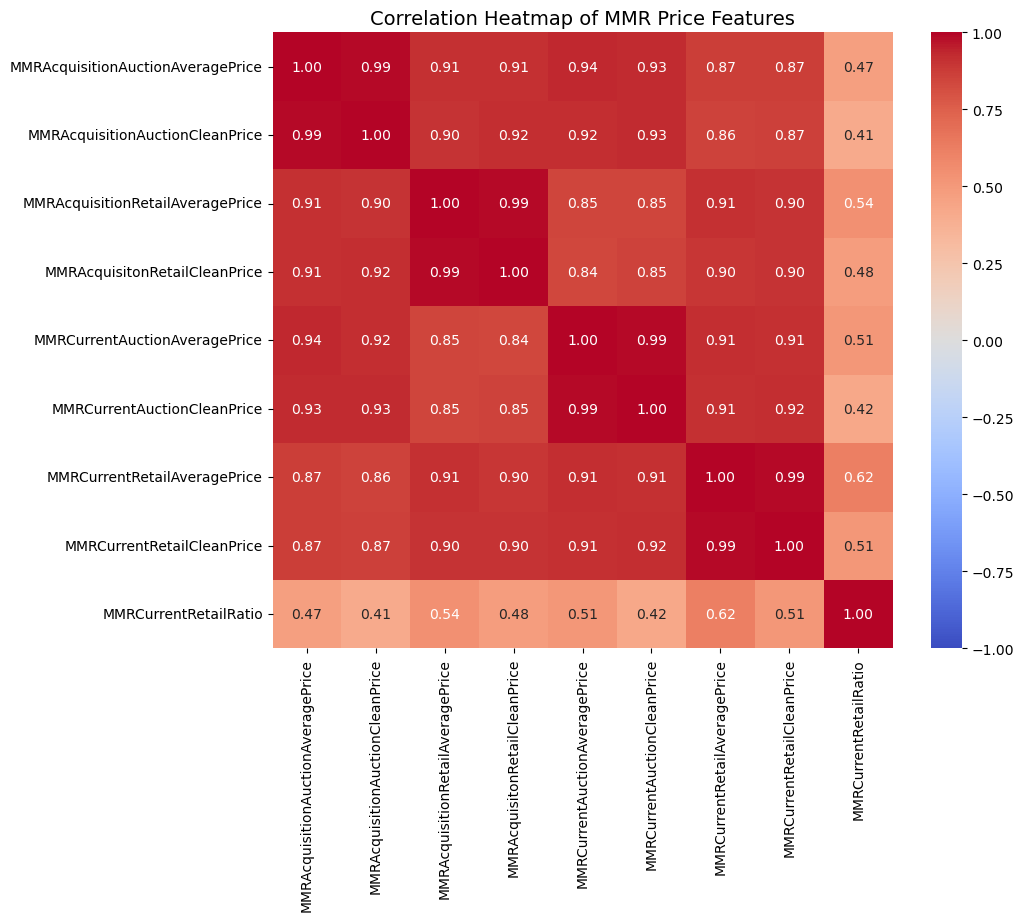

In [109]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of MMR Price Features", fontsize=14)
plt.show()

The outputs show that several pairs exhibited near-perfect correlations (0.99), specifically between the “average” and “clean” condition prices for the same market and time period. It means that hese columns contain essentially the same information.To reduce redundancy while preserving information, one column from each highly correlated pair was retained, and the corresponding “clean” price variables were removed. The MMRCurrentRetailRatio was retained due to its moderate correlations with other features.

In [110]:
# Drop missing values for comparison
d = df[["WheelTypeID", "WheelType"]].dropna()

#Check how many unique WheelTypeID values per WheelType
check1 = d.groupby("WheelTypeID")["WheelType"].nunique()

#Check how many unique WheelType values per WheelTypeID
check2 = d.groupby("WheelType")["WheelTypeID"].nunique()

print("WheelTypeID -> WheelType unique counts:")
print(check1)

print("\nWheelType -> WheelTypeID unique counts:")
print(check2)

WheelTypeID -> WheelType unique counts:
WheelTypeID
0    1
1    1
2    1
3    1
?    1
Name: WheelType, dtype: int64

WheelType -> WheelTypeID unique counts:
WheelType
?          2
Alloy      1
Covers     1
Special    1
Name: WheelTypeID, dtype: int64


C:\Users\23179\AppData\Local\Temp\ipykernel_28192\4192757827.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  check1 = d.groupby("WheelTypeID")["WheelType"].nunique()
C:\Users\23179\AppData\Local\Temp\ipykernel_28192\4192757827.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  check2 = d.groupby("WheelType")["WheelTypeID"].nunique()


The output above means there’s a one-to-one mapping between WheelTypeID and WheelType.

In [111]:
# Drop redundant columns

redundant_columns = [ "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailCleanPrice",
    "PurchaseDate","WheelTypeID"]

df = df.drop(columns=redundant_columns)

Handling missing values

In [112]:
print(df.isnull().sum().sort_values(ascending=False))

MMRCurrentRetailRatio                538
MMRCurrentRetailAveragePrice         251
MMRCurrentAuctionAveragePrice        231
WheelType                             96
VehBCost                              73
MMRAcquisitionAuctionAveragePrice     67
MMRAcquisitionRetailAveragePrice      54
IsOnlineSale                          46
VehOdo                                44
Nationality                           44
Size                                  44
TopThreeAmericanName                  44
Auction                               44
Transmission                          44
Color                                 44
Make                                  44
PRIMEUNIT                             44
AUCGUART                              44
VNST                                  44
VehYear                               44
WarrantyCost                          44
ForSale                                0
PurchaseTimestamp                      0
IsBadBuy                               0
dtype: int64


I checked the unique values of each column.
This helps us quickly see if there are unexpected values. I exclude obvious identifiers like PurchaseID and PurchaseTimestamp to get a cleaner output.

In [113]:
id_columns = ["PurchaseID", "PurchaseTimestamp"]

# Loop through non-identifier columns
for col in df.columns:
    if col not in id_columns:
        unique_vals = df[col].unique()
        print(f"Column: {col}")
        print(f"Unique values ({len(unique_vals)}): {unique_vals}")
        print("-" * 50)

Column: Auction
Unique values (4): ['OTHER', 'MANHEIM', NaN, 'ADESA']
Categories (3, object): ['ADESA', 'MANHEIM', 'OTHER']
--------------------------------------------------
Column: VehYear
Unique values (11): [2008. 2007. 2004. 2006. 2005. 2003. 2009. 2001. 2002.   nan 2010.]
--------------------------------------------------
Column: Make
Unique values (31): ['DODGE', 'CHRYSLER', 'CHEVROLET', 'PONTIAC', 'MITSUBISHI', ..., 'SCION', 'LEXUS', 'MINI', 'VOLVO', NaN]
Length: 31
Categories (30, object): ['ACURA', 'BUICK', 'CADILLAC', 'CHEVROLET', ..., 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']
--------------------------------------------------
Column: Color
Unique values (18): ['RED', 'SILVER', 'WHITE', 'BLUE', 'BEIGE', ..., 'YELLOW', 'OTHER', 'BROWN', NaN, '?']
Length: 18
Categories (17, object): ['?', 'BEIGE', 'BLACK', 'BLUE', ..., 'RED', 'SILVER', 'WHITE', 'YELLOW']
--------------------------------------------------
Column: Transmission
Unique values (5): ['AUTO', 'MANUAL', 'Manual', NaN

Data Quality Issues identified from the output above:

Inconsistent casing:

Transmission: 'AUTO', 'MANUAL', 'Manual'

ForSale: 'Yes', 'No', 'yes', '0', 'YES'

Different representations for missing data:

For example, '?' appears in multiple columns.

errors: IsOnlineSale is supposed to only contain two unique values 0 and 1, as it is a binary variable. However, it contains values like -1.

"NOT AVAI" in the Color column could mean the car’s color can’t be identified because of damage (paint stripped, etc.), then it’s not just a missing value but might actually be a risk signal for a kick.

So, we should treat it as a distinct value.

This allows the model to learn that "NOT AVAI" might increase the probability of IsBadBuy = 1.

In [156]:
#fix inconsistent casing and errors

df['Transmission'] = df['Transmission'].str.upper().str.strip()

df['ForSale'] = df['ForSale'].astype(str).str.strip().str.lower()

ForSaleMask = df['ForSale'] == '0'
df.loc[ForSaleMask,'ForSale'] = np.nan

df['IsOnlineSale'] = df['IsOnlineSale'].replace({
    -1: np.nan,   
    2: np.nan,    
    3: np.nan,    
    4: np.nan     
}).astype('int64')


In [157]:
#confirm the results

print(df['Transmission'].unique())
print(df['ForSale'].unique())
print(df['IsOnlineSale'].unique())

['AUTO' 'MANUAL']
['yes' 'no']
[0 1]


Standardizing the missing values

In [158]:
placeholders = ['?','',' ']

df = df.replace(placeholders, np.nan)

In [159]:
print(df.isnull().sum().sort_values(ascending=False))

PurchaseTimestamp                    0
Auction                              0
ForSale                              0
WarrantyCost                         0
IsOnlineSale                         0
VehBCost                             0
VNST                                 0
MMRCurrentRetailRatio                0
MMRCurrentRetailAveragePrice         0
MMRCurrentAuctionAveragePrice        0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitionAuctionAveragePrice    0
TopThreeAmericanName                 0
Size                                 0
Nationality                          0
VehOdo                               0
WheelType                            0
Transmission                         0
Color                                0
Make                                 0
VehYear                              0
IsBadBuy                             0
dtype: int64


The output above revealed that AUCGUART and PRIMEUNIT have extremely high missingness.Most other variables have relatively low missingness. For columns with extremely low missingness, we could remove the rows with missing values. The prices columns are correlated, so we could consider using regression methods to impute the missing values.

In [160]:
# Count rows before
rows_before = len(df)
print(f"Rows before: {rows_before}")

Rows before: 40814


In [161]:
# Columns with low missingness
low_na_cols = [
    'Transmission', 'Color', 'Nationality', 'Size', 'TopThreeAmericanName',
    'IsOnlineSale', 'Make', 'Auction', 'VehYear', 'VNST',
    'WarrantyCost', 'VehOdo','ForSale'
]

# Drop rows with missing values in any of these columns
df = df.dropna(subset=low_na_cols)

print(f"Rows before: {rows_before}, Rows after: {len(df)}")

Rows before: 40814, Rows after: 40814


In [162]:
print(df.isnull().sum().sort_values(ascending=False))

PurchaseTimestamp                    0
Auction                              0
ForSale                              0
WarrantyCost                         0
IsOnlineSale                         0
VehBCost                             0
VNST                                 0
MMRCurrentRetailRatio                0
MMRCurrentRetailAveragePrice         0
MMRCurrentAuctionAveragePrice        0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitionAuctionAveragePrice    0
TopThreeAmericanName                 0
Size                                 0
Nationality                          0
VehOdo                               0
WheelType                            0
Transmission                         0
Color                                0
Make                                 0
VehYear                              0
IsBadBuy                             0
dtype: int64


In [163]:
#Examing the correlations of columns with high missing values to investigate which columns could be excluded from further analysis. 

 
high_na_cols = ['AUCGUART','PRIMEUNIT']

#I store the categirical cols to a new df, and perform one-hot-encoding on them to compute the correlation.

# Store only those columns
df_encoded = df[high_na_cols].copy()

# One-hot encode
df_encoded = pd.get_dummies(df_encoded, columns=high_na_cols, drop_first=True)

# Add target column
df_encoded['IsBadBuy'] = df['IsBadBuy']

# Compute correlation
high_na_corr = df_encoded.corr()['IsBadBuy'].sort_values(ascending=False)

print(high_na_corr)

KeyError: "None of [Index(['AUCGUART', 'PRIMEUNIT'], dtype='object')] are in the [columns]"

The correlations are not very high, so, these high na columns should be dropped.

In [164]:
non_corr_cols = ['AUCGUART','PRIMEUNIT']
df.drop(columns=non_corr_cols, inplace=True)

KeyError: "['AUCGUART', 'PRIMEUNIT'] not found in axis"

In [165]:
print(df.isnull().sum().sort_values(ascending=False))

PurchaseTimestamp                    0
Auction                              0
ForSale                              0
WarrantyCost                         0
IsOnlineSale                         0
VehBCost                             0
VNST                                 0
MMRCurrentRetailRatio                0
MMRCurrentRetailAveragePrice         0
MMRCurrentAuctionAveragePrice        0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitionAuctionAveragePrice    0
TopThreeAmericanName                 0
Size                                 0
Nationality                          0
VehOdo                               0
WheelType                            0
Transmission                         0
Color                                0
Make                                 0
VehYear                              0
IsBadBuy                             0
dtype: int64


Imputation

For qualitative(nominal) variables like WheelType, we impute the missing values with mode.

In [166]:


mode_impute_cols = ['WheelType']
for col in mode_impute_cols:
    df[col].fillna(df[col].mode()[0],inplace=True)

C:\Users\23179\AppData\Local\Temp\ipykernel_28192\2193990463.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0],inplace=True)


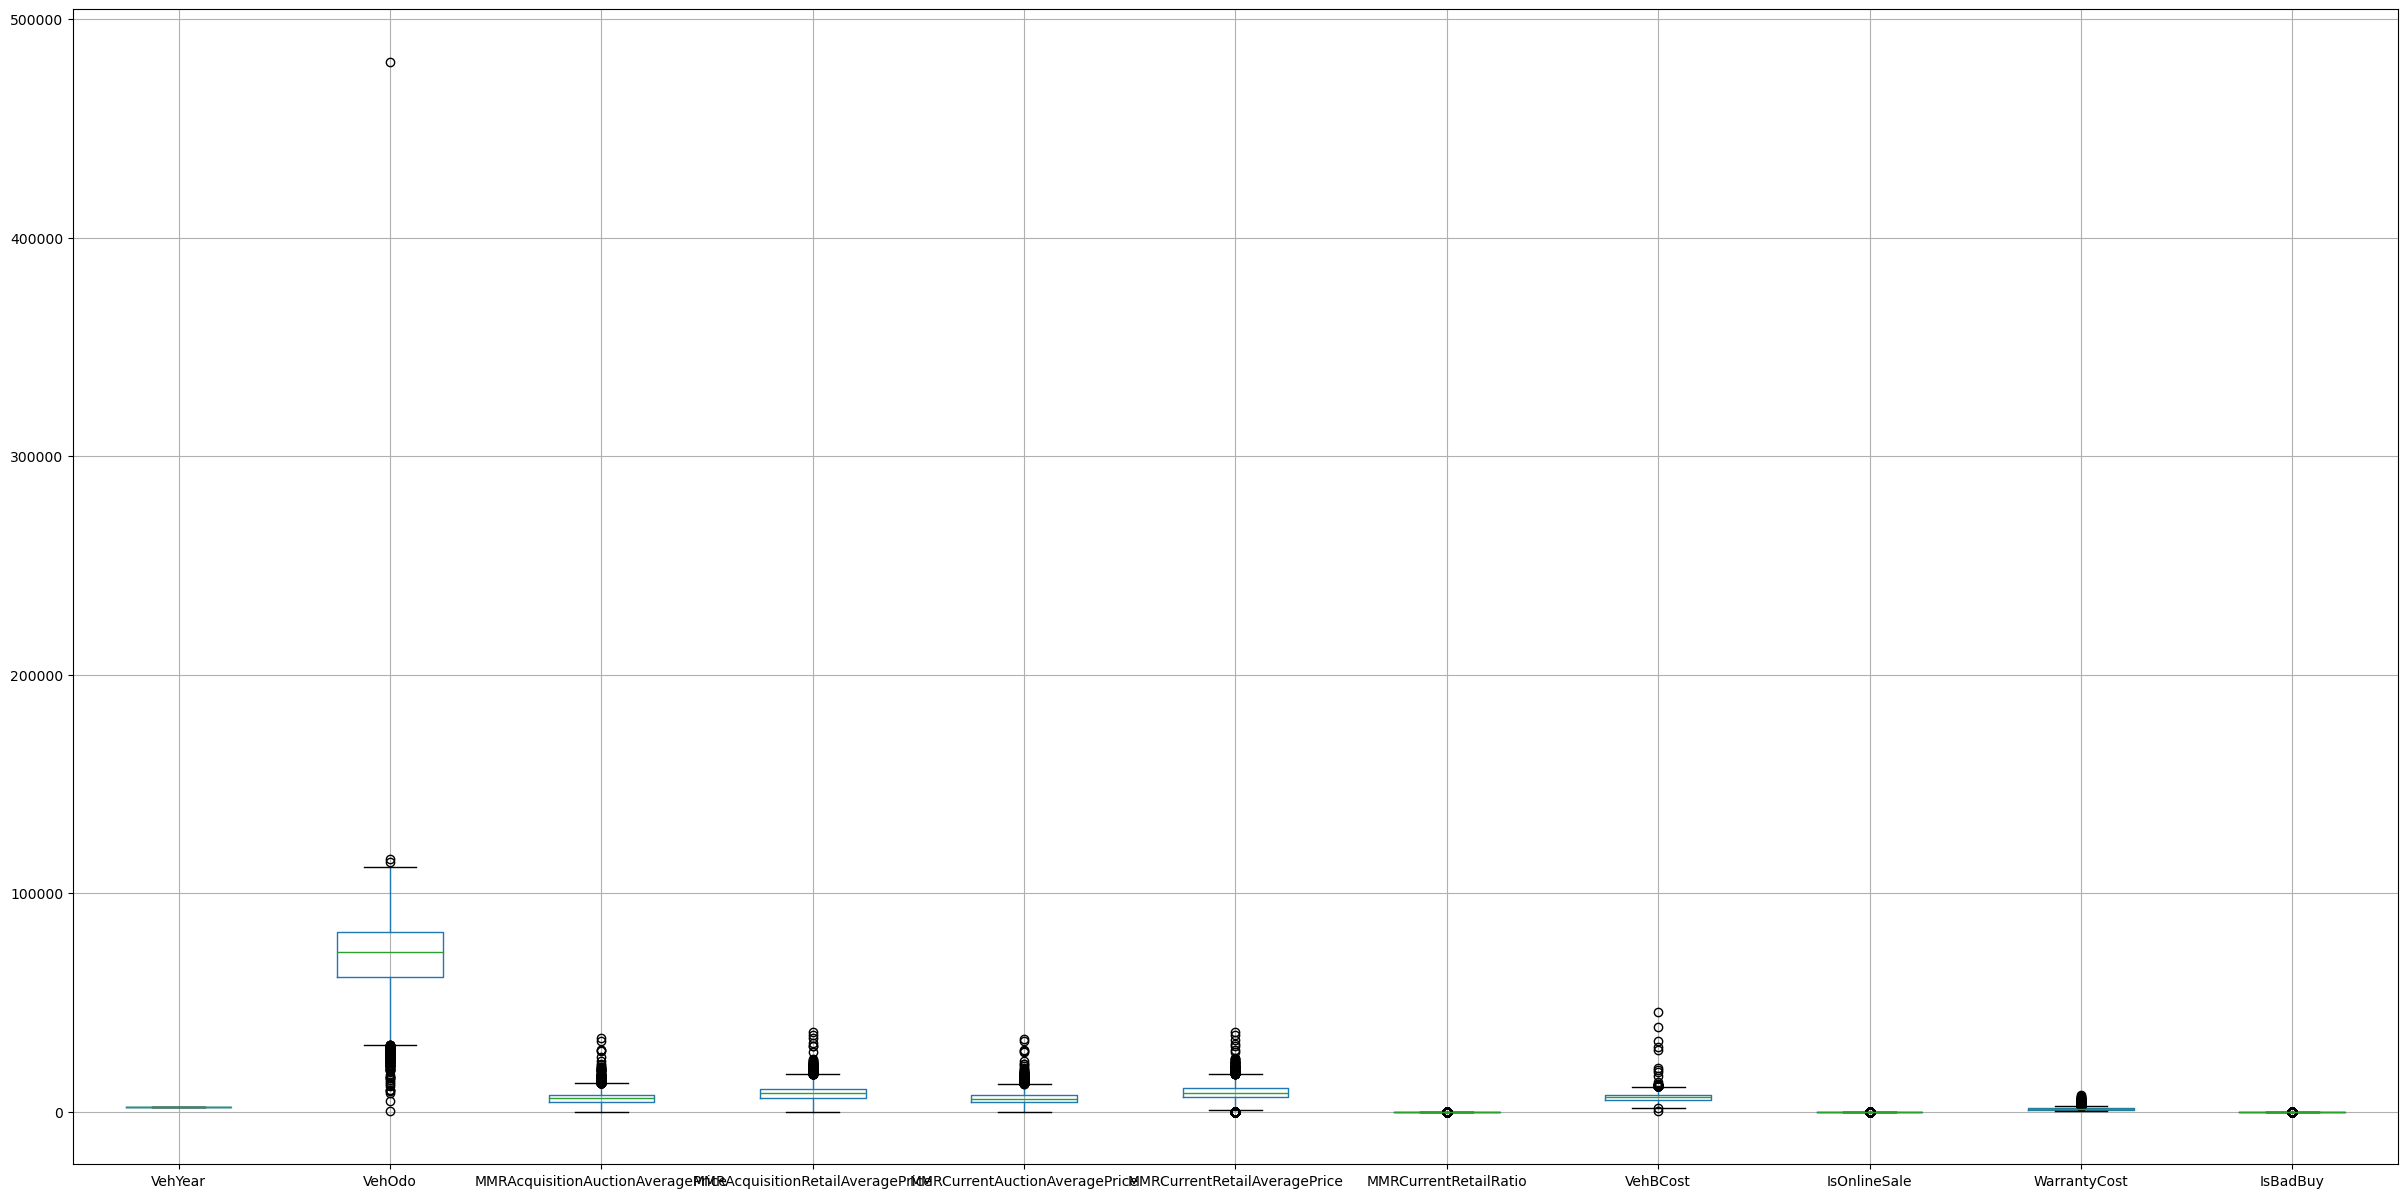

In [167]:
#checking outliers

fig = plt.figure(figsize =(30, 15))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

df[numeric_cols].boxplot()
plt.show()

The output above shows that all the numerical columns with missing values contain outliers. So, we impute the missing values in these columns with the medians.

In [168]:
median_impute_cols = ['MMRCurrentRetailAveragePrice',
'MMRCurrentAuctionAveragePrice',
'VehBCost',
'MMRAcquisitionAuctionAveragePrice',
'MMRAcquisitionRetailAveragePrice',
'MMRCurrentRetailRatio']
for col in median_impute_cols:
    df[col].fillna(df[col].median(),inplace=True)

C:\Users\23179\AppData\Local\Temp\ipykernel_28192\1507117406.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(),inplace=True)


In [169]:
print(df.isnull().sum().sort_values(ascending=False))

PurchaseTimestamp                    0
Auction                              0
ForSale                              0
WarrantyCost                         0
IsOnlineSale                         0
VehBCost                             0
VNST                                 0
MMRCurrentRetailRatio                0
MMRCurrentRetailAveragePrice         0
MMRCurrentAuctionAveragePrice        0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitionAuctionAveragePrice    0
TopThreeAmericanName                 0
Size                                 0
Nationality                          0
VehOdo                               0
WheelType                            0
Transmission                         0
Color                                0
Make                                 0
VehYear                              0
IsBadBuy                             0
dtype: int64


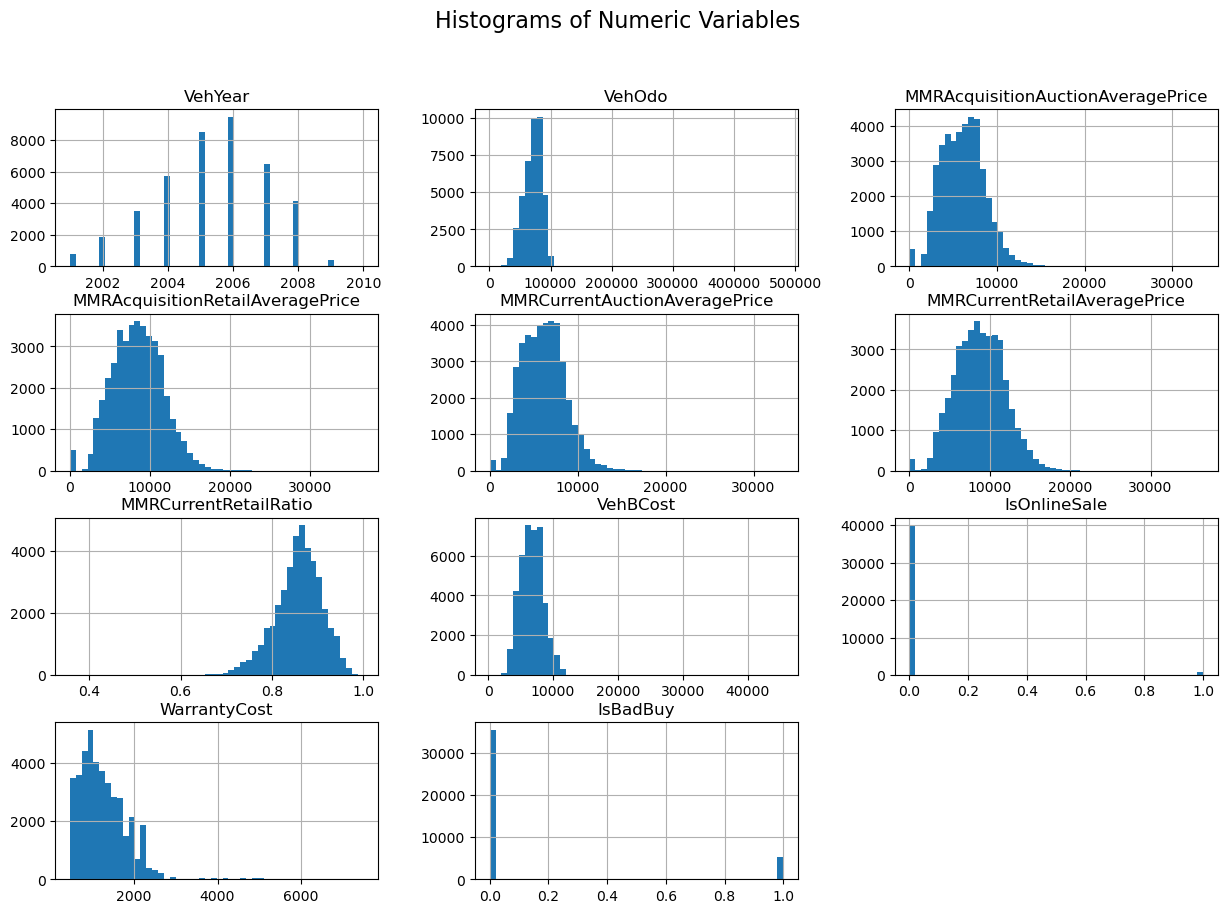

In [171]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

df[numeric_cols].hist(bins=50, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Variables", fontsize=16)
plt.show()

In [ ]:
# Calculate proportion of values of the target variable after cleaning

after_counts = df["IsBadBuy"].value_counts(dropna=False)
after_proportion = after_counts / len(df)

print("After preprocessing:")
print(pd.DataFrame({"Count": after_counts, "Proportion": after_proportion}))

After preprocessing:
          Count  Proportion
IsBadBuy                   
0         35537    0.870706
1          5277    0.129294


After preprocessing, the target variable IsBadBuy consists of:

Class 0 (Good Buy): 0.870706% of records

Class 1 (Bad Buy):  0.129294% of records

Missing: 0% of records